# CSC 487 – GeoGuessr Bot: Dataset EDA
**Taran Singh & Hannah Moshtaghi**  
*November 2025*

This notebook analyzes the GeoGuessr 50k image dataset to justify data cleaning decisions:
1. Identifying countries with insufficient samples (single-image countries)
2. Analyzing image dimensions to identify and remove non-standard sizes (1030x1030)

In [59]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import kagglehub
from tqdm.auto import tqdm

In [60]:
# Dataset path - auto-detect local data or download from Kaggle
LOCAL_PATH = Path("../compressed_dataset")

if LOCAL_PATH.exists():
    DATA_ROOT = LOCAL_PATH
    print(f"Using local data: {DATA_ROOT}")
else:
    print("Local data not found, downloading from Kaggle...")
    root = Path(kagglehub.dataset_download("ubitquitin/geolocation-geoguessr-images-50k"))
    DATA_ROOT = root / "compressed_dataset"
    print(f"Downloaded to: {DATA_ROOT}")

print(f"DATA_ROOT exists: {DATA_ROOT.exists()}")

# Initialize plot styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

Using local data: ../compressed_dataset
DATA_ROOT exists: True


In [61]:
# build a master dataframe with data about each entry in the dataset

rows = []
country_paths = [p for p in DATA_ROOT.iterdir() if p.is_dir()]
for country_path in tqdm(country_paths, desc="Countries"):
    if not country_path.is_dir():
        continue
    country = country_path.name
    images = list(country_path.glob("*.jpg")) + list(country_path.glob("*.jpeg")) + list(country_path.glob("*.png"))
    for img_path in images:
        try:
            with Image.open(img_path) as im:
                width, height = im.size
            rows.append({
                "path": str(img_path),
                "country": country,
                "width": width,
                "height": height,
                "aspect_ratio": width / height
            })
        except Exception as e:
            print(f"Corrupted image: {img_path}")

df = pd.DataFrame(rows)
print(f"Total images loaded: {len(df):,}")
print(f"Total countries: {df['country'].nunique()}")
df.head()

Countries: 100%|██████████| 124/124 [00:13<00:00,  8.96it/s]

Total images loaded: 49,997
Total countries: 124


,path,country,width,height,aspect_ratio
0,../compressed_dataset/Bhutan/canvas_1629262074...,Bhutan,1536,662,2.320242
1,../compressed_dataset/Bhutan/canvas_1629527767...,Bhutan,1536,662,2.320242
2,../compressed_dataset/Bhutan/canvas_1629551780...,Bhutan,1536,662,2.320242
3,../compressed_dataset/Bhutan/canvas_1629992395...,Bhutan,1536,662,2.320242
4,../compressed_dataset/Bhutan/canvas_1629687800...,Bhutan,1536,662,2.320242


SINGLE-IMAGE COUNTRIES (Candidates for Removal)

Total countries with only 1 image: 13

These countries are:
  - Nepal
  - Armenia
  - South Sudan
  - Pitcairn Islands
  - Svalbard and Jan Mayen
  - Qatar
  - South Georgia and South Sandwich Islands
  - Venezuela
  - Antarctica
  - Mozambique
  - Tanzania
  - Belarus
  - Gibraltar


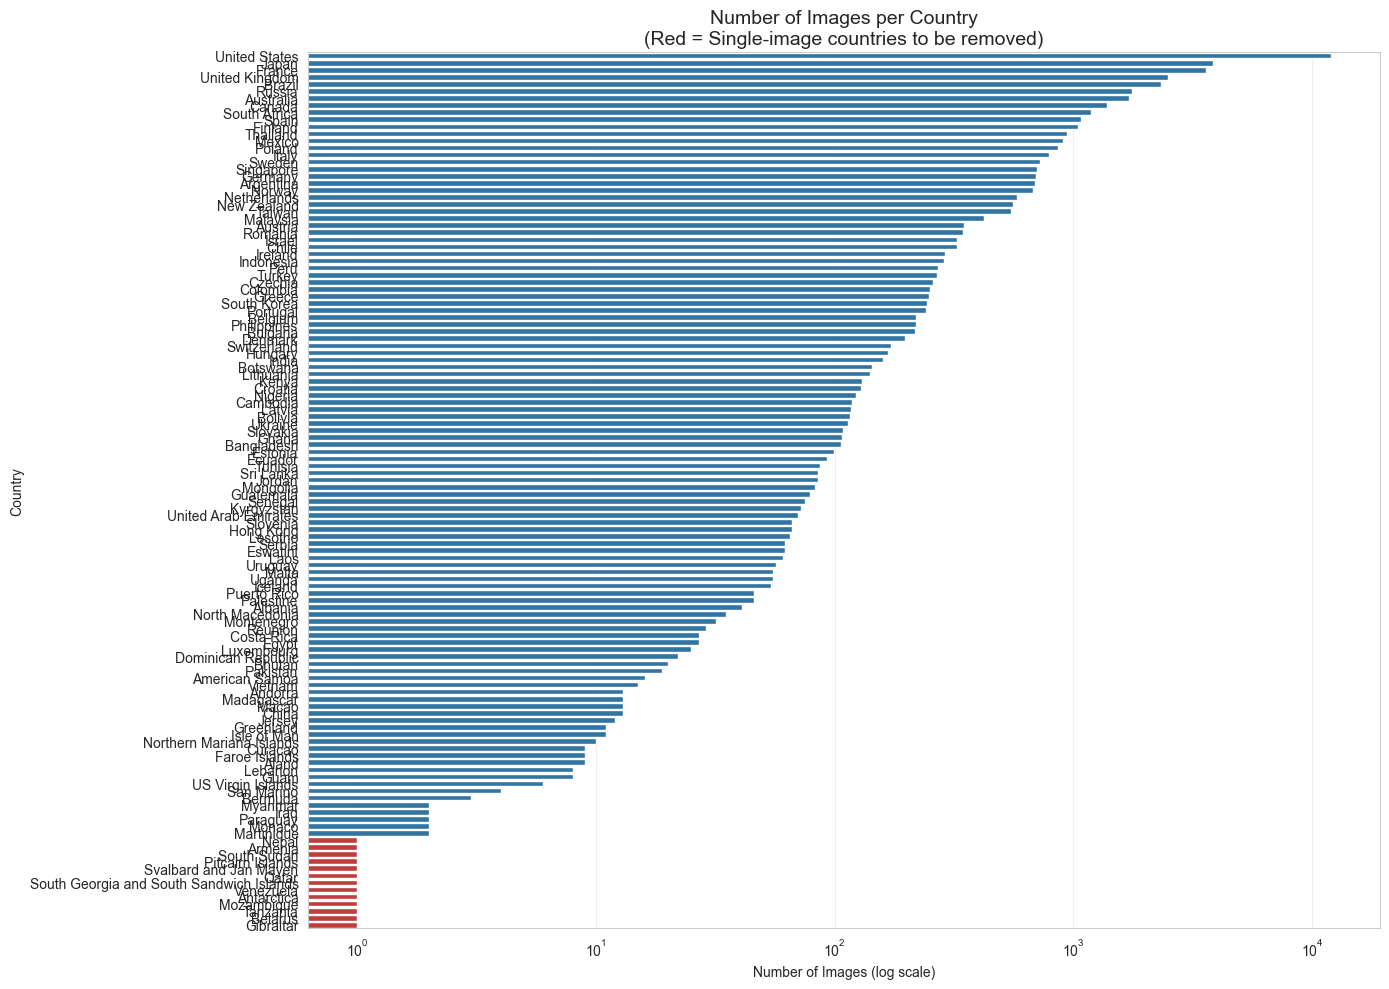


SUMMARY STATISTICS
Total images: 49,997
Total countries: 124
Countries with only 1 image: 13
Countries remaining after removal: 111


In [62]:
# =============================================================================
# 1a. CLASS DISTRIBUTION: Images per Country
# =============================================================================

country_counts = df['country'].value_counts().sort_values(ascending=False)

# Count countries with only 1 image
single_image_countries = country_counts[country_counts == 1]
num_single_image_countries = len(single_image_countries)

print("=" * 60)
print("SINGLE-IMAGE COUNTRIES (Candidates for Removal)")
print("=" * 60)
print(f"\nTotal countries with only 1 image: {num_single_image_countries}")
print(f"\nThese countries are:")
for country in single_image_countries.index:
    print(f"  - {country}")

# Bar chart
plt.figure(figsize=(14, 10))
colors = ['#d62728' if count == 1 else '#1f77b4' for count in country_counts.values]
sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, 
            palette=colors, legend=False)
plt.title("Number of Images per Country\n(Red = Single-image countries to be removed)", fontsize=14)
plt.xlabel("Number of Images (log scale)")
plt.ylabel("Country")
plt.xscale("log")
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("eda_images_per_country.png", dpi=200, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Total images: {len(df):,}")
print(f"Total countries: {len(country_counts)}")
print(f"Countries with only 1 image: {num_single_image_countries}")
print(f"Countries remaining after removal: {len(country_counts) - num_single_image_countries}")

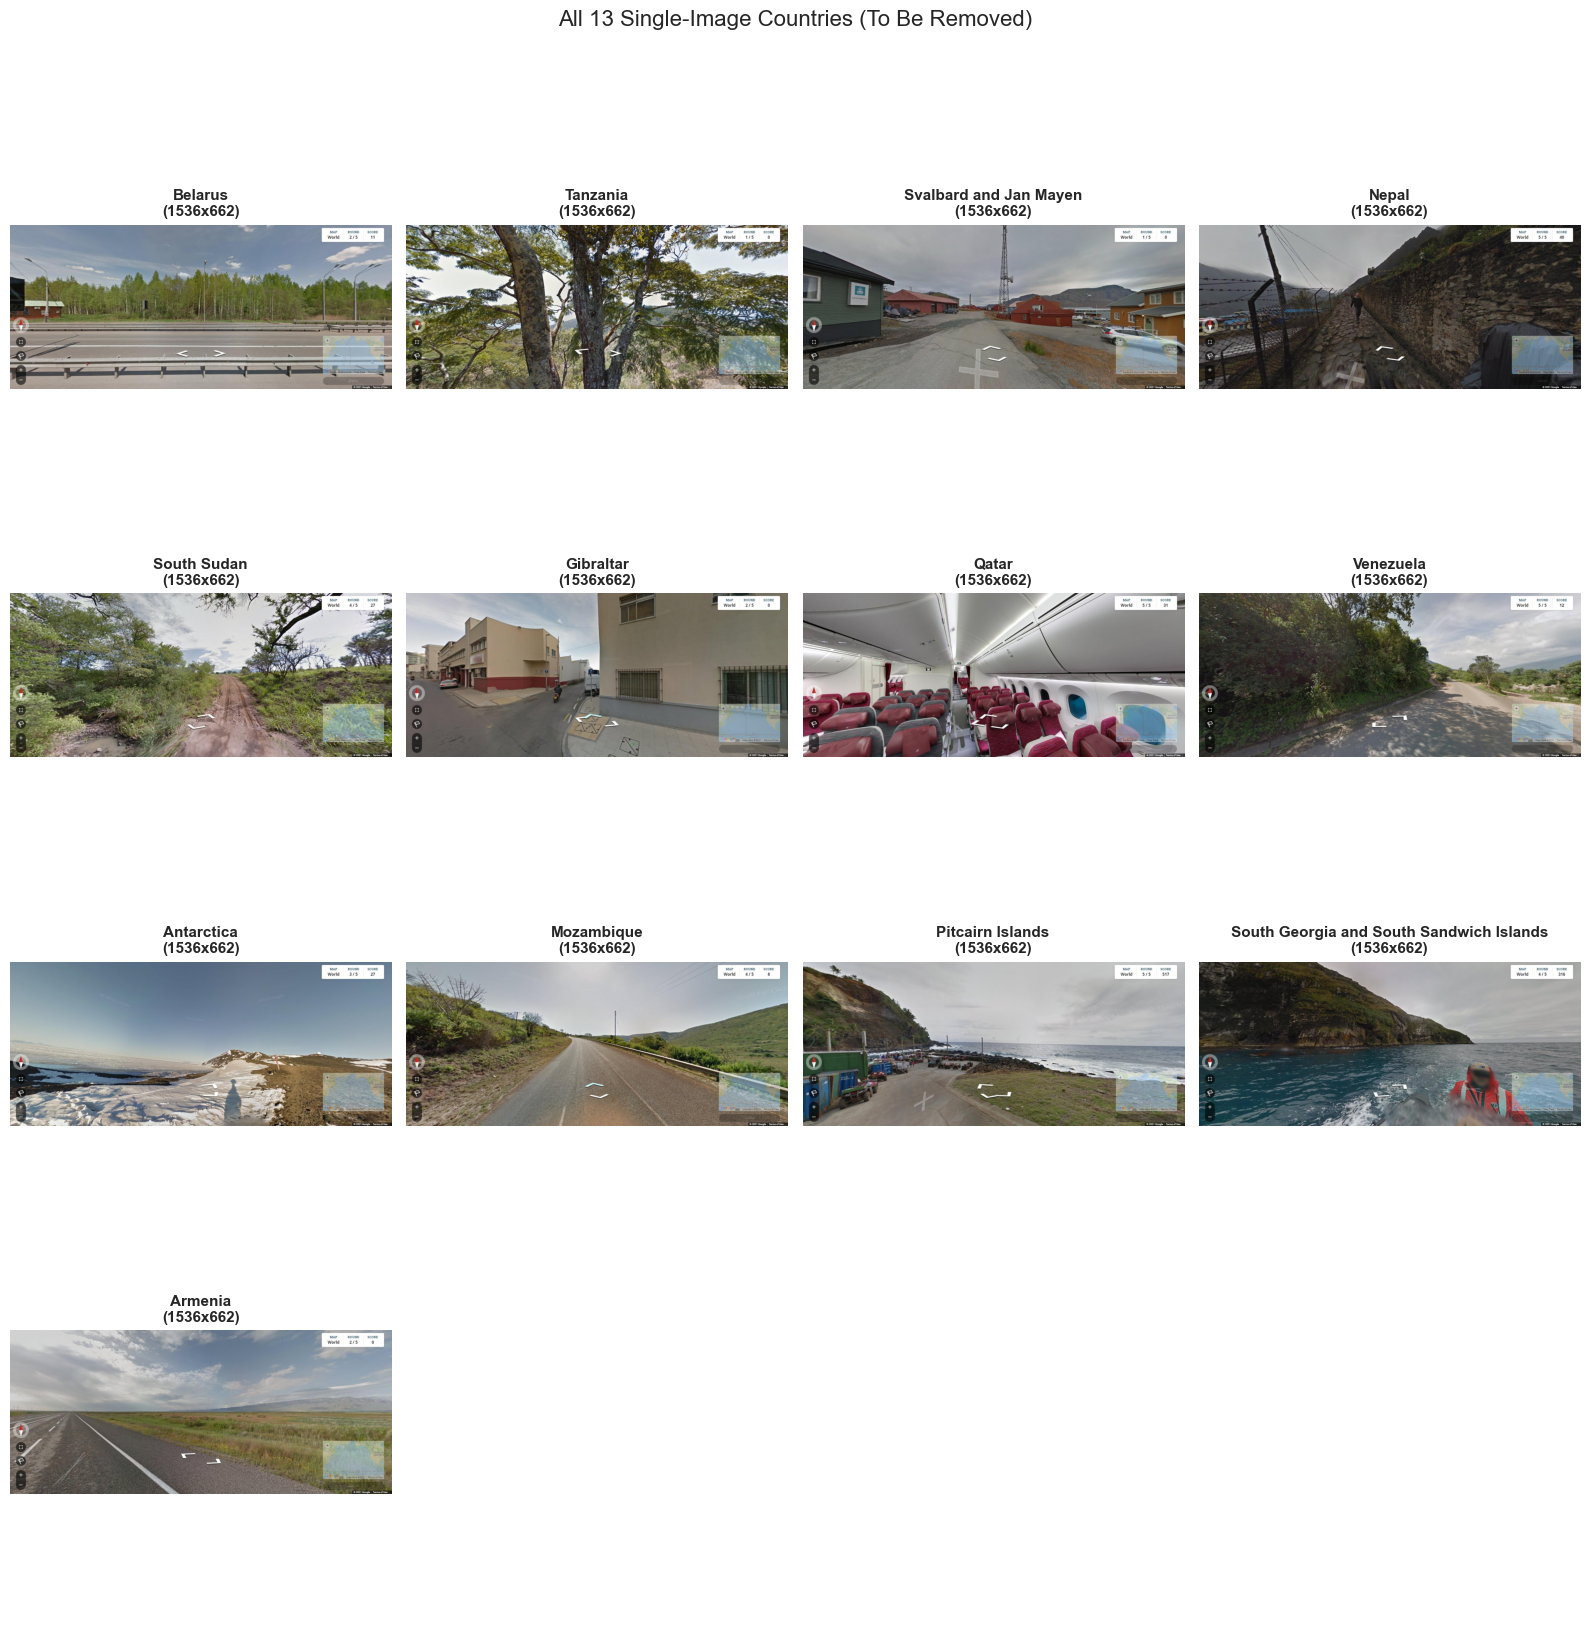


These 13 countries have only 1 image each - not enough for training/validation split.


In [63]:
# =============================================================================
# 1b. VISUALIZE ALL SINGLE-IMAGE COUNTRIES
# =============================================================================

# Get images from single-image countries
single_img_data = df[df['country'].isin(single_image_countries.index)]

# Calculate grid size
n_images = len(single_img_data)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.ravel() if n_images > 1 else [axes]

for i, (_, row) in enumerate(single_img_data.iterrows()):
    img = Image.open(row['path'])
    axes[i].imshow(img)
    axes[i].set_title(f"{row['country']}\n({row['width']}x{row['height']})", fontsize=11, fontweight='bold')
    axes[i].axis('off')

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"All {n_images} Single-Image Countries (To Be Removed)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("eda_single_image_countries.png", dpi=200, bbox_inches='tight')
plt.show()

print(f"\nThese {n_images} countries have only 1 image each - not enough for training/validation split.")


IMAGE DIMENSIONS DISTRIBUTION

Unique dimension sizes found: 2

Breakdown:
  1536x662: 49,942 images (99.89%)
  1030x703: 55 images (0.11%)

IMPACT OF REMOVING 1030x703 IMAGES

Majority dimension: 1536x662 (49,942 images)
Minority dimension: 1030x703 (55 images)

If we remove minority dimension:
  - Images removed: 55
  - Images retained: 49,942


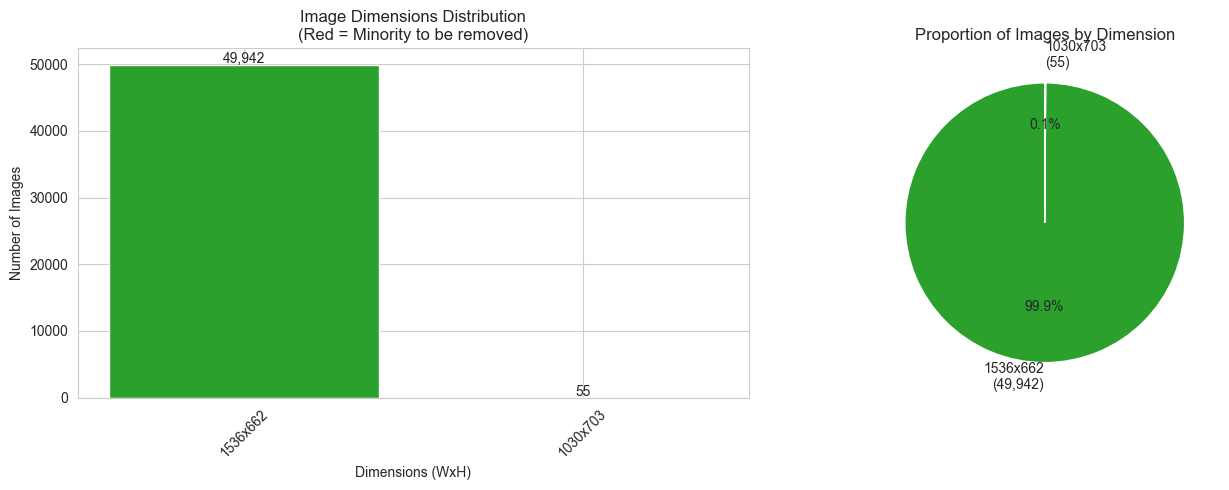

In [64]:
# =============================================================================
# 2a. IMAGE DIMENSIONS ANALYSIS
# =============================================================================

# Create dimension string for grouping
df['dimensions'] = df['width'].astype(str) + 'x' + df['height'].astype(str)
dimension_counts = df['dimensions'].value_counts()

print("=" * 60)
print("IMAGE DIMENSIONS DISTRIBUTION")
print("=" * 60)
print(f"\nUnique dimension sizes found: {len(dimension_counts)}")
print("\nBreakdown:")
for dim, count in dimension_counts.items():
    pct = count / len(df) * 100
    print(f"  {dim}: {count:,} images ({pct:.2f}%)")

# Dynamically identify majority and minority dimensions
majority_dim = dimension_counts.index[0]  # Most common
minority_dim = dimension_counts.index[1] if len(dimension_counts) > 1 else None

minority_images = df[df['dimensions'] == minority_dim] if minority_dim else pd.DataFrame()
majority_images = df[df['dimensions'] == majority_dim]

print(f"\n" + "=" * 60)
print(f"IMPACT OF REMOVING {minority_dim} IMAGES")
print("=" * 60)
print(f"\nMajority dimension: {majority_dim} ({len(majority_images):,} images)")
print(f"Minority dimension: {minority_dim} ({len(minority_images):,} images)")
print(f"\nIf we remove minority dimension:")
print(f"  - Images removed: {len(minority_images):,}")
print(f"  - Images retained: {len(majority_images):,}")

# Bar chart of dimension distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall dimension distribution
colors = ['#d62728' if dim == minority_dim else '#2ca02c' for dim in dimension_counts.index]
axes[0].bar(dimension_counts.index, dimension_counts.values, color=colors)
axes[0].set_title('Image Dimensions Distribution\n(Red = Minority to be removed)', fontsize=12)
axes[0].set_xlabel('Dimensions (WxH)')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)
for i, (dim, count) in enumerate(dimension_counts.items()):
    axes[0].text(i, count + 200, f'{count:,}', ha='center', fontsize=10)

# Right: Pie chart showing proportion
if len(minority_images) > 0:
    axes[1].pie([len(majority_images), len(minority_images)], 
                labels=[f'{majority_dim}\n({len(majority_images):,})', f'{minority_dim}\n({len(minority_images):,})'],
                colors=['#2ca02c', '#d62728'],
                autopct='%1.1f%%',
                startangle=90,
                explode=(0, 0.1))
    axes[1].set_title('Proportion of Images by Dimension', fontsize=12)
else:
    axes[1].text(0.5, 0.5, 'Only one dimension found', ha='center', va='center')
    axes[1].axis('off')

plt.tight_layout()
plt.savefig("eda_image_dimensions.png", dpi=200, bbox_inches='tight')
plt.show()

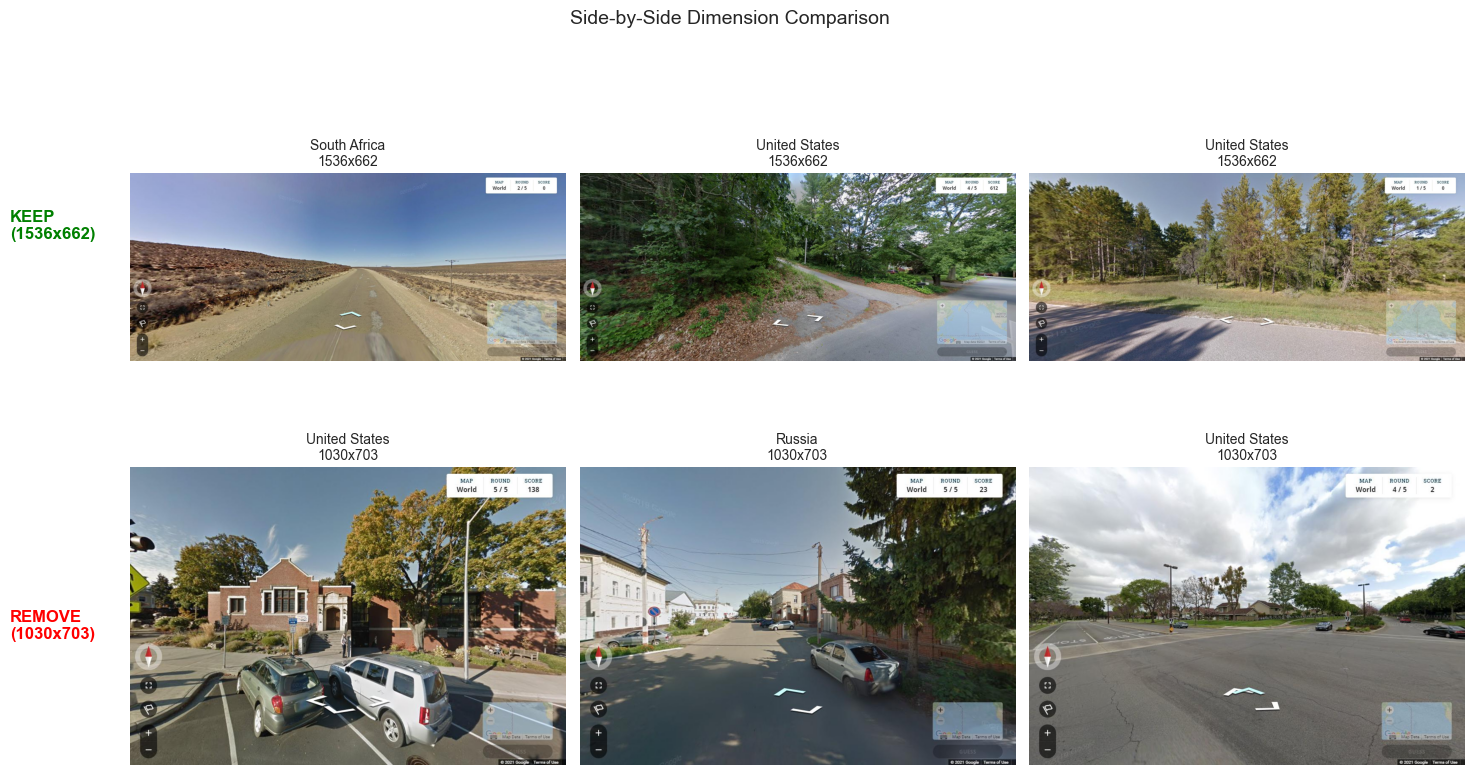


Dimension Details:
  Majority: 1536x662 (aspect ratio: 2.32)
  Minority: 1030x703 (aspect ratio: 1.47)


In [65]:
# =============================================================================
# 2b. VISUAL COMPARISON OF THE TWO DIMENSIONS
# =============================================================================

if minority_dim and len(minority_images) > 0:
    # Sample images from each dimension
    n_samples = min(3, len(minority_images))  # Show up to 3 of each
    
    majority_samples = majority_images.sample(n=n_samples, random_state=42)
    minority_samples = minority_images.sample(n=min(n_samples, len(minority_images)), random_state=42)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(5 * n_samples, 8))
    
    # Top row: Majority dimension
    for i, (_, row) in enumerate(majority_samples.iterrows()):
        img = Image.open(row['path'])
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{row['country']}\n{majority_dim}", fontsize=10)
        axes[0, i].axis('off')
    
    # Bottom row: Minority dimension  
    for i, (_, row) in enumerate(minority_samples.iterrows()):
        img = Image.open(row['path'])
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"{row['country']}\n{minority_dim}", fontsize=10)
        axes[1, i].axis('off')
    
    # Hide empty subplots if minority has fewer samples
    for i in range(len(minority_samples), n_samples):
        axes[1, i].axis('off')
    
    # Add row labels
    fig.text(0.02, 0.75, f'KEEP\n({majority_dim})', fontsize=12, fontweight='bold', 
             color='green', va='center', ha='left')
    fig.text(0.02, 0.25, f'REMOVE\n({minority_dim})', fontsize=12, fontweight='bold', 
             color='red', va='center', ha='left')
    
    plt.suptitle('Side-by-Side Dimension Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)
    plt.savefig("eda_dimension_comparison.png", dpi=200, bbox_inches='tight')
    plt.show()
    
    # Print dimension details
    maj_w, maj_h = majority_dim.split('x')
    min_w, min_h = minority_dim.split('x')
    print(f"\nDimension Details:")
    print(f"  Majority: {maj_w}x{maj_h} (aspect ratio: {int(maj_w)/int(maj_h):.2f})")
    print(f"  Minority: {min_w}x{min_h} (aspect ratio: {int(min_w)/int(min_h):.2f})")
else:
    print("Only one dimension found in dataset - no comparison needed.")


COUNTRIES AFFECTED BY REMOVING 1030x703 IMAGES

Total countries affected: 28

Breakdown by country (showing all affected):
--------------------------------------------------
Country                        Removed    Total      %Loss
--------------------------------------------------
United States                  8          12014      0.1%
Japan                          6          3840       0.2%
Brazil                         4          2320       0.2%
France                         4          3573       0.1%
Canada                         3          1382       0.2%
Sweden                         3          726        0.4%
South Africa                   2          1183       0.2%
Russia                         2          1761       0.1%
Australia                      2          1704       0.1%
Norway                         2          675        0.3%
Germany                        2          698        0.3%
Mexico                         1          901        0.1%
Montenegro          

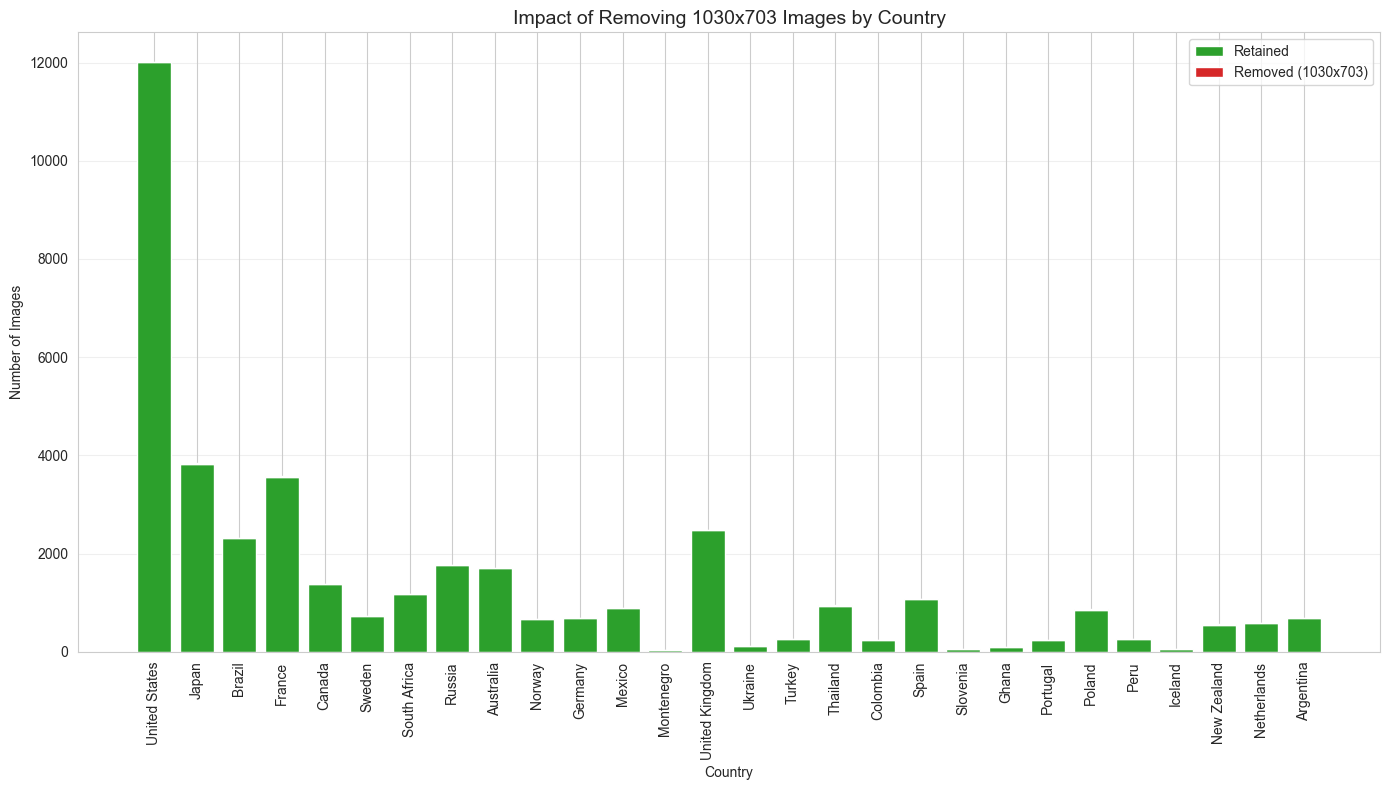

In [66]:
# =============================================================================
# 3. COUNTRY-LEVEL IMPACT OF REMOVING MINORITY DIMENSION IMAGES
# =============================================================================

if minority_dim and len(minority_images) > 0:
    # Count minority dimension images per country
    minority_by_country = minority_images.groupby('country').size().sort_values(ascending=False)
    total_by_country = df.groupby('country').size()

    # Countries affected by the removal
    affected_countries = minority_by_country[minority_by_country > 0]

    print("=" * 60)
    print(f"COUNTRIES AFFECTED BY REMOVING {minority_dim} IMAGES")
    print("=" * 60)
    print(f"\nTotal countries affected: {len(affected_countries)}")
    print(f"\nBreakdown by country (showing all affected):")
    print("-" * 50)
    print(f"{'Country':<30} {'Removed':<10} {'Total':<10} {'%Loss'}")
    print("-" * 50)
    for country, removed in affected_countries.items():
        total = total_by_country[country]
        pct = removed / total * 100
        print(f"{country:<30} {removed:<10} {total:<10} {pct:.1f}%")

    # Visualize: stacked bar showing impact per country
    fig, ax = plt.subplots(figsize=(14, 8))

    affected_df = pd.DataFrame({
        'country': affected_countries.index,
        'removed': affected_countries.values,
        'kept': [total_by_country[c] - affected_countries[c] for c in affected_countries.index]
    })

    x = range(len(affected_df))
    ax.bar(x, affected_df['kept'], label='Retained', color='#2ca02c')
    ax.bar(x, affected_df['removed'], bottom=affected_df['kept'], label=f'Removed ({minority_dim})', color='#d62728')
    ax.set_xticks(x)
    ax.set_xticklabels(affected_df['country'], rotation=90, ha='center')
    ax.set_xlabel('Country')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Impact of Removing {minority_dim} Images by Country', fontsize=14)
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig("eda_dimension_impact_by_country.png", dpi=200, bbox_inches='tight')
    plt.show()
else:
    print("No minority dimension images to analyze.")

In [67]:
# =============================================================================
# 4. FINAL SUMMARY: COMBINED DATA CLEANING IMPACT
# =============================================================================

print("=" * 70)
print("FINAL DATA CLEANING SUMMARY")
print("=" * 70)

# Calculate combined effect
single_img_country_names = set(single_image_countries.index)

# Clean dataset: remove single-image countries AND minority dimension
clean_df = df[
    (~df['country'].isin(single_img_country_names))
]
if minority_dim:
    clean_df = clean_df[clean_df['dimensions'] != minority_dim]

print(f"\nOriginal dataset:")
print(f"  - Total images: {len(df):,}")
print(f"  - Total countries: {df['country'].nunique()}")
print(f"  - Dimensions: {majority_dim} and {minority_dim}")

print(f"\nRemovals:")
print(f"  - Single-image countries: {num_single_image_countries} countries ({num_single_image_countries} images)")
print(f"  - {minority_dim} images: {len(minority_images):,} images")

print(f"\nFinal clean dataset:")
print(f"  - Total images: {len(clean_df):,}")
print(f"  - Total countries: {clean_df['country'].nunique()}")
print(f"  - Images removed: {len(df) - len(clean_df):,} ({(len(df) - len(clean_df)) / len(df) * 100:.2f}%)")

print("\n" + "=" * 70)
print(f"RECOMMENDATION: Remove single-image countries and {minority_dim} images")
print("=" * 70)

FINAL DATA CLEANING SUMMARY

Original dataset:
  - Total images: 49,997
  - Total countries: 124
  - Dimensions: 1536x662 and 1030x703

Removals:
  - Single-image countries: 13 countries (13 images)
  - 1030x703 images: 55 images

Final clean dataset:
  - Total images: 49,929
  - Total countries: 111
  - Images removed: 68 (0.14%)

RECOMMENDATION: Remove single-image countries and 1030x703 images
